In [ ]:
!nvidia-smi

Mon Mar 22 17:15:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.000715856days (61.85sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

In [ ]:
!pip install -e ./custom_ImageNet

In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 317kB 12.6MB/s 


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/cortical_ImagenetTrain3.zip" /content/
!cp "drive/My Drive/ImageNet/cortical_ImagenetTest2.zip" /content/

In [ ]:
!unzip -nq "cortical_ImagenetTrain3.zip"
!unzip -nq "cortical_ImagenetTest2.zip"

In [ ]:
rootpathTrain ='cortical_ImagenetTrain3/'
rootpathTest ='cortical_ImagenetTest2/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
def str_convert(label):
    df = pd.DataFrame(({'label_' : label}))
    df['label_'] = df['label_'].astype('category')
    df.dtypes
    df['label'] = df['label_'].cat.codes
    label = df['label'].tolist()

    return label

In [ ]:
class ImageNetDataset(data.Dataset):
    def __init__(self, img_list, phase, transform):
        self.img_list = img_list
        self.label_name = [x.split("/")[1] for x in img_list]
        self.label = str_convert(self.label_name)
        self.phase = phase
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        """
        Return pre-processed tensor images and labels
        """
        #img, anno_class_img, label = self.pull_item(index)
        #return img, anno_class_img, label
        img, label = self.pull_item(index)
        return img, label
    
    def get_label_relation(self):
        df = pd.DataFrame({'name' : self.label_name, 'num' : self.label})
        classes_list=df[~df.duplicated()].sort_values(by='num')['name'].values.tolist()
        
        return classes_list

    def pull_item(self, index):
        # read image
        image_file_path = self.img_list[index]
        img = PIL.Image.open(image_file_path).convert("RGB")   # [height][width][RGB]
        
        # transform
        #img = transforms.functional.to_tensor(img)
        #anno_class_img = torch.from_numpy(anno_class_img)
        img = self.transform(img)
        #anno_class_img = self.transform(anno_class_img)

        # label
        label = self.label[index]
        
        #return img, anno_class_img, label
        return img, label

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
#classes_list = train_dataset.get_label_relation()
classes_list = test_dataset.get_label_relation()


In [ ]:
batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


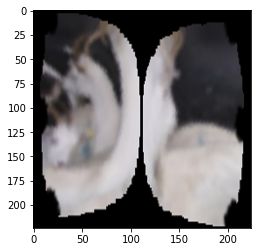

In [ ]:
index = 2
imges, label = test_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 2
else:
    NUM_EPOCS = 40

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

### Model preparation

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):

    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### VGG16 fine tuning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = True
net = models.vgg16(pretrained=use_pretrained)

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)

params_to_update_1 stores： features.0.weight
params_to_update_1 stores： features.0.bias
params_to_update_1 stores： features.2.weight
params_to_update_1 stores： features.2.bias
params_to_update_1 stores： features.5.weight
params_to_update_1 stores： features.5.bias
params_to_update_1 stores： features.7.weight
params_to_update_1 stores： features.7.bias
params_to_update_1 stores： features.10.weight
params_to_update_1 stores： features.10.bias
params_to_update_1 stores： features.12.weight
params_to_update_1 stores： features.12.bias
params_to_update_1 stores： features.14.weight
params_to_update_1 stores： features.14.bias
params_to_update_1 stores： features.17.weight
params_to_update_1 stores： features.17.bias
params_to_update_1 stores： features.19.weight
params_to_update_1 stores： features.19.bias
params_to_update_1 stores： features.21.weight
params_to_update_1 stores： features.21.bias
params_to_update_1 stores： features.24.weight
params_to_update_1 stores： features.24.bias
params_to_update_1

In [ ]:
vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)

In [ ]:
LOAD_STATE = False
EPOCH = 40             # This values need to check the latest tar ffile name with epoch.
name = "05_VGG_fine"
folder_name = "VGG_fine"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    use_pretrained = True
    best_model = models.mobilenet_v2()
    best_model.classifier[1] = nn.Linear(in_features=1280, out_features=N_CLASSES)
    best_model.cuda()
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/PhD/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    optimizer.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/40
-------------



86543
train Loss: 0.0378 Acc: 61.1318



25374
val Loss: 0.0271 Acc: 71.6942
-------------
Epoch 2/40
-------------



102402
train Loss: 0.0264 Acc: 72.3341



26722
val Loss: 0.0232 Acc: 75.5029
-------------
Epoch 3/40
-------------



108757
train Loss: 0.0220 Acc: 76.8232



27461
val Loss: 0.0212 Acc: 77.5910
-------------
Epoch 4/40
-------------



113663
train Loss: 0.0186 Acc: 80.2886



28013
val Loss: 0.0196 Acc: 79.1507
-------------
Epoch 5/40
-------------



117979
train Loss: 0.0157 Acc: 83.3373



28670
val Loss: 0.0180 Acc: 81.0070
-------------
Epoch 6/40
-------------



122041
train Loss: 0.0129 Acc: 86.2066



29087
val Loss: 0.0170 Acc: 82.1852
-------------
Epoch 7/40
-------------



125629
train Loss: 0.0104 Acc: 88.7411



29325
val Loss: 0.0168 Acc: 82.8577
-------------
Epoch 8/40
-------------



128955
train Loss: 0.0082 Acc: 91.0905



29828
val Loss: 0.0157 Acc: 84.2789
-------------
Epoch 9/40
-------------



131588
train Loss: 0.0064 Acc: 92.9504



29944
val Loss: 0.0160 Acc: 84.6067
-------------
Epoch 10/40
-------------



133999
train Loss: 0.0049 Acc: 94.6535



30062
val Loss: 0.0161 Acc: 84.9401
-------------
Epoch 11/40
-------------



135631
train Loss: 0.0038 Acc: 95.8063



30141
val Loss: 0.0177 Acc: 85.1633
-------------
Epoch 12/40
-------------



136778
train Loss: 0.0031 Acc: 96.6165



30361
val Loss: 0.0167 Acc: 85.7849
-------------
Epoch 13/40
-------------



137817
train Loss: 0.0025 Acc: 97.3504



30231
val Loss: 0.0186 Acc: 85.4176
-------------
Epoch 14/40
-------------



138544
train Loss: 0.0020 Acc: 97.8639



30577
val Loss: 0.0174 Acc: 86.3952
-------------
Epoch 15/40
-------------



138935
train Loss: 0.0017 Acc: 98.1401



30339
val Loss: 0.0188 Acc: 85.7228
-------------
Epoch 16/40
-------------



139384
train Loss: 0.0015 Acc: 98.4573



30682
val Loss: 0.0182 Acc: 86.6919
-------------
Epoch 17/40
-------------



139566
train Loss: 0.0013 Acc: 98.5858



30686
val Loss: 0.0183 Acc: 86.7032
-------------
Epoch 18/40
-------------



139973
train Loss: 0.0011 Acc: 98.8733



30596
val Loss: 0.0193 Acc: 86.4489
-------------
Epoch 19/40
-------------



140060
train Loss: 0.0010 Acc: 98.9348



30662
val Loss: 0.0192 Acc: 86.6354
-------------
Epoch 20/40
-------------



140169
train Loss: 0.0009 Acc: 99.0118



30684
val Loss: 0.0193 Acc: 86.6976
-------------
Epoch 21/40
-------------



140323
train Loss: 0.0008 Acc: 99.1206



30766
val Loss: 0.0198 Acc: 86.9292
-------------
Epoch 22/40
-------------



140555
train Loss: 0.0007 Acc: 99.2844



30858
val Loss: 0.0201 Acc: 87.1892
-------------
Epoch 23/40
-------------



140564
train Loss: 0.0007 Acc: 99.2908



30675
val Loss: 0.0195 Acc: 86.6721
-------------
Epoch 24/40
-------------



140693
train Loss: 0.0006 Acc: 99.3819



30803
val Loss: 0.0204 Acc: 87.0338
-------------
Epoch 25/40
-------------



140644
train Loss: 0.0006 Acc: 99.3473



30797
val Loss: 0.0194 Acc: 87.0168
-------------
Epoch 26/40
-------------



140797
train Loss: 0.0005 Acc: 99.4554



30917
val Loss: 0.0202 Acc: 87.3559
-------------
Epoch 27/40
-------------



140876
train Loss: 0.0005 Acc: 99.5112



30772
val Loss: 0.0217 Acc: 86.9462
-------------
Epoch 28/40
-------------



140830
train Loss: 0.0005 Acc: 99.4787



30844
val Loss: 0.0196 Acc: 87.1496
-------------
Epoch 29/40
-------------



140968
train Loss: 0.0004 Acc: 99.5762



30929
val Loss: 0.0206 Acc: 87.3898
-------------
Epoch 30/40
-------------



140978
train Loss: 0.0004 Acc: 99.5832



30823
val Loss: 0.0205 Acc: 87.0903
-------------
Epoch 31/40
-------------



141000
train Loss: 0.0004 Acc: 99.5988



30943
val Loss: 0.0203 Acc: 87.4294
-------------
Epoch 32/40
-------------



140971
train Loss: 0.0004 Acc: 99.5783



30853
val Loss: 0.0207 Acc: 87.1751
-------------
Epoch 33/40
-------------



141023
train Loss: 0.0004 Acc: 99.6150



31001
val Loss: 0.0205 Acc: 87.5932
-------------
Epoch 34/40
-------------



141105
train Loss: 0.0003 Acc: 99.6729



30840
val Loss: 0.0213 Acc: 87.1383
-------------
Epoch 35/40
-------------



141103
train Loss: 0.0003 Acc: 99.6715



30851
val Loss: 0.0212 Acc: 87.1694
-------------
Epoch 36/40
-------------



141134
train Loss: 0.0003 Acc: 99.6934



30907
val Loss: 0.0218 Acc: 87.3276
-------------
Epoch 37/40
-------------



141181
train Loss: 0.0003 Acc: 99.7266



30975
val Loss: 0.0214 Acc: 87.5198
-------------
Epoch 38/40
-------------



141123
train Loss: 0.0003 Acc: 99.6857



30852
val Loss: 0.0222 Acc: 87.1722
-------------
Epoch 39/40
-------------



141184
train Loss: 0.0003 Acc: 99.7288



30962
val Loss: 0.0215 Acc: 87.4830
-------------
Epoch 40/40
-------------



141207
train Loss: 0.0002 Acc: 99.7450



31063
val Loss: 0.0213 Acc: 87.7684
-------------
Lowest training loss 0.00024448432903407754
Lowest validation loss 0.01572628283644159
Highest training accuracy 99.74499886980108
Highest validation accuracy 87.76842224231464
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/04_2_VGG_fine_Loss _.png04_2_VGG_fine_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/04_2_VGG_fine_Accuracy _.png04_2_VGG_fine_Accuracy _.png


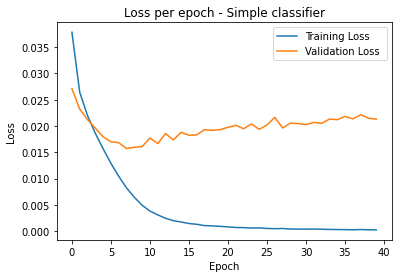

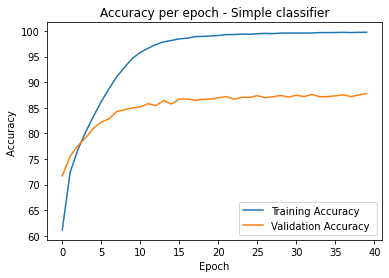

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: 0.8644 
Testing Accuracy: 1712/2000 (85.60%)
apple Class Accuracy: 80/100 (80.00%)
banana Class Accuracy: 83/100 (83.00%)
bear Class Accuracy: 93/100 (93.00%)
bell_pepper Class Accuracy: 88/100 (88.00%)
bird Class Accuracy: 86/100 (86.00%)
broccoli Class Accuracy: 87/100 (87.00%)
cat Class Accuracy: 90/100 (90.00%)
cauliflower Class Accuracy: 78/100 (78.00%)
cow Class Accuracy: 69/100 (69.00%)
dog Class Accuracy: 74/100 (74.00%)
elephant Class Accuracy: 94/100 (94.00%)
fox Class Accuracy: 92/100 (92.00%)
goat Class Accuracy: 69/100 (69.00%)
horse Class Accuracy: 83/100 (83.00%)
mashed_potato Class Accuracy: 92/100 (92.00%)
orange Class Accuracy: 91/100 (91.00%)
pineapple Class Accuracy: 88/100 (88.00%)
pomegranate Class Accuracy: 92/100 (92.00%)
tomato Class Accuracy: 90/100 (90.00%)
zebra Class Accuracy: 93/100 (93.00%)
Classifier has Acc=0.856 P=0.856 R=0.858 F1=0.855
               precision    recall  f1-score   support

        apple       0.78      0.80      0.79     

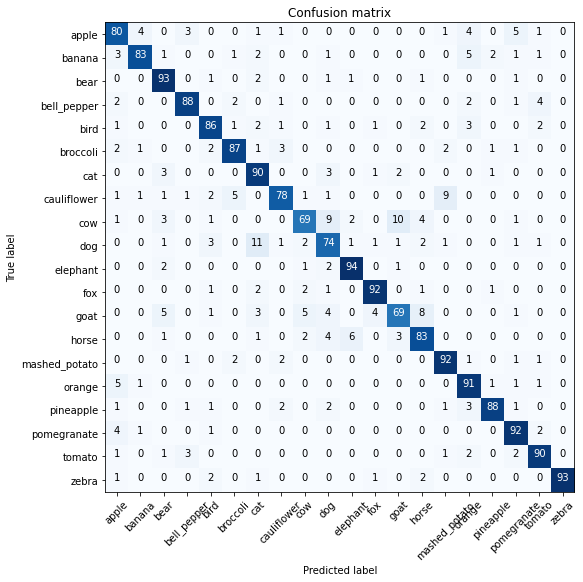

In [ ]:
result = test_model(best_vgg2,criterion, name)